In [7]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.theodolite_utils as ttfu
import time
from tqdm import tqdm
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)

In [18]:
def drop_points_filtering(file_name_path, param):
    number_points_input = []
    number_points_out_outliers = []
    number_points_out_filters_only = []
    number_points_out_filters = []
    number_points_out_outliers_end_with_outliers = []
    number_points_out_outliers_end_without_ouliers = []
    
    for i in file_name_path:
        print(i)
        
        # Data filtered with outliers
        t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = ttfu.read_rosbag_theodolite_without_tf_raw_data_pre_filtered(i)
        index_1_f = ttfu.thresold_raw_data(t1, d1, a1, e1, param[0], param[1]*3.1415926/180, param[2]*3.1415926/180, param[3])
        index_2_f = ttfu.thresold_raw_data(t2, d2, a2, e2, param[0], param[1]*3.1415926/180, param[2]*3.1415926/180, param[3])
        index_3_f = ttfu.thresold_raw_data(t3, d3, a3, e3, param[0], param[1]*3.1415926/180, param[2]*3.1415926/180, param[3])
        t1 = t1[index_1_f]
        t2 = t2[index_2_f]
        t3 = t3[index_3_f]
        tp1 = tp1[index_1_f].T
        tp2 = tp2[index_2_f].T
        tp3 = tp3[index_3_f].T

        # Raw data
        tr1, tr2, tr3, trp1, trp2, trp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = ttfu.read_rosbag_theodolite_without_tf_raw_data(i)

        sum_input_points = len(tr1)+len(tr2)+len(tr3)
        sum_outliers_points = len(t1)+len(t2)+len(t3)
        
        # data filtered in pipeline
        list_interval, list_time = tfu.split_time_interval_all_data(t1, t2, t3, param[3])
        list_trajectories_split = tfu.merge_interval(list_interval, list_time, t1, t2, t3, param[3])
        
        sum_filters_points = 0
        sum_filters_points_with_outliers = 0
        
        for j in tqdm(list_trajectories_split):
            index_1 = np.array([j[0,0],j[1,0]])
            index_2 = np.array([j[0,1],j[1,1]])
            index_3 = np.array([j[0,2],j[1,2]])
            
            sum_filters_points = sum_filters_points + len(t1[index_1[0]:index_1[1]]) + len(t2[index_2[0]:index_2[1]]) + len(t3[index_3[0]:index_3[1]])
            
            index_1 = GPf.delta_t_function(index_1,t1,param[4])
            index_2 = GPf.delta_t_function(index_2,t2,param[4])
            index_3 = GPf.delta_t_function(index_3,t3,param[4])
                
            begin = np.max([t1[index_1[0]], t2[index_2[0]], t3[index_3[0]]])
            end = np.min([t1[index_1[1]], t2[index_2[1]], t3[index_3[1]]])

            if(abs(end-begin)>param[5] and begin<end):
                sum_filters_points_with_outliers = sum_filters_points_with_outliers + len(t1[index_1[0]:index_1[1]]) + len(t2[index_2[0]:index_2[1]]) + len(t3[index_3[0]:index_3[1]]) 
            
        # Raw data in pipeline
        list_interval, list_time = tfu.split_time_interval_all_data(tr1, tr2, tr3, param[3])
        list_trajectories_split = tfu.merge_interval(list_interval, list_time, tr1, tr2, tr3, param[3])
        
        sum_filters_points_only = 0
        sum_filters_points_without_outliers = 0
        
        for j in tqdm(list_trajectories_split):
            index_1 = np.array([j[0,0],j[1,0]])
            index_2 = np.array([j[0,1],j[1,1]])
            index_3 = np.array([j[0,2],j[1,2]])
            
            sum_filters_points_only = sum_filters_points_only + len(tr1[index_1[0]:index_1[1]]) + len(tr2[index_2[0]:index_2[1]]) + len(tr3[index_3[0]:index_3[1]])

            index_1 = GPf.delta_t_function(index_1,tr1,param[4])
            index_2 = GPf.delta_t_function(index_2,tr2,param[4])
            index_3 = GPf.delta_t_function(index_3,tr3,param[4])
                
            begin = np.max([tr1[index_1[0]], tr2[index_2[0]], tr3[index_3[0]]])
            end = np.min([tr1[index_1[1]], tr2[index_2[1]], tr3[index_3[1]]])

            if(abs(end-begin)>param[5] and begin<end):
                sum_filters_points_without_outliers = sum_filters_points_without_outliers + len(tr1[index_1[0]:index_1[1]]) + len(tr2[index_2[0]:index_2[1]]) + len(tr3[index_3[0]:index_3[1]]) 

        number_points_input.append(sum_input_points)
        number_points_out_outliers.append(sum_outliers_points)
        number_points_out_filters.append(sum_filters_points)
        number_points_out_filters_only.append(sum_filters_points_only)
        number_points_out_outliers_end_with_outliers.append(sum_filters_points_with_outliers)
        number_points_out_outliers_end_without_ouliers.append(sum_filters_points_without_outliers)

    print("Results done !")
    
    return number_points_input, number_points_out_outliers, number_points_out_filters, number_points_out_filters_only, number_points_out_outliers_end_with_outliers, number_points_out_outliers_end_without_ouliers

In [19]:
file = ["/home/norlab/Data/IROS_2022/20220224_TS/2022-02-24-15-34-38.bag"
        #"/home/norlab/Data/IROS_2022/20220307_TS/2022-03-07-19-20-06.bag",
        #"/home/norlab/Data/IROS_2022/20220312_TS/2022-03-12-09-45-12.bag",
        #"/home/norlab/Data/IROS_2022/20220314_TS/2022-03-14-10-47-49.bag",
        #"/home/norlab/Data/IROS_2022/20220316_TS/2022-03-16-19-02-42.bag",
        #"/home/norlab/Data/IROS_2022/20220331_TS/2022-03-31-10-22-52.bag",
        #"/home/norlab/Data/IROS_2022/20220331_TS/2022-03-31-11-20-05.bag",
        #"/home/norlab/Data/IROS_2022/20220427_TS/2022-04-27-12-12-10_filered.bag",
        #"/home/norlab/Data/IROS_2022/20220505_TS/empty1_2022-05-05-19-14-33.bag",
        #"/home/norlab/Data/IROS_2022/20220505_TS/cones1_2022-05-05-19-25-54.bag"
       ]

param = [np.array([1, 10, 10, 1, 0, 6]),
         np.array([1.5, 10, 10, 1, 0, 6]),
         np.array([2, 10, 10, 1, 0, 6]),
         np.array([2.5, 10, 10, 1, 0, 6])]

In [32]:
mean_points_input = []
mean_point_out_outlier = []
mean_point_out_filter = []
mean_point_out_filter_only = []
mean_points_out_outliers_end_with_outliers = []
mean_points_out_outliers_end_without_outliers = []
for i in param:
    number_points_input, number_points_out_outliers, number_points_out_filters, number_points_out_filters_only, number_points_out_outliers_end_with_outliers, number_points_out_outliers_end_without_ouliers = drop_points_filtering(file, i)
    mean_points_input.append(np.sum(number_points_input))
    mean_point_out_outlier.append(np.sum(number_points_out_outliers))
    mean_point_out_filter.append(np.sum(number_points_out_filters))
    mean_point_out_filter_only.append(np.sum(number_points_out_filters_only))
    mean_points_out_outliers_end_with_outliers.append(np.sum(number_points_out_outliers_end_with_outliers))
    mean_points_out_outliers_end_without_outliers.append(np.sum(number_points_out_outliers_end_without_ouliers))
    

/home/norlab/Data/IROS_2022/20220224_TS/2022-02-24-15-34-38.bag
Number of data for theodolites: [4945 4681 4737]
Bad measures: 558
Number of data for theodolites: [4945 4681 4737]
Bad measures: 558


100%|██████████| 199/199 [00:00<00:00, 22443.30it/s]


Results done !
/home/norlab/Data/IROS_2022/20220224_TS/2022-02-24-15-34-38.bag
Number of data for theodolites: [4945 4681 4737]
Bad measures: 558
Number of data for theodolites: [4945 4681 4737]
Bad measures: 558


100%|██████████| 199/199 [00:00<00:00, 28850.25it/s]


Results done !
/home/norlab/Data/IROS_2022/20220224_TS/2022-02-24-15-34-38.bag
Number of data for theodolites: [4945 4681 4737]
Bad measures: 558
Number of data for theodolites: [4945 4681 4737]
Bad measures: 558


100%|██████████| 199/199 [00:00<00:00, 28010.82it/s]


Results done !
/home/norlab/Data/IROS_2022/20220224_TS/2022-02-24-15-34-38.bag
Number of data for theodolites: [4945 4681 4737]
Bad measures: 558
Number of data for theodolites: [4945 4681 4737]
Bad measures: 558


100%|██████████| 199/199 [00:00<00:00, 26201.23it/s]

Results done !


In [33]:
percentage_out_outliers = []
percentage_out_filters = []
percentage_out_total = []
percentage_out_outliers_with_outliers = []
percentage_out_outliers_without_outliers = []
for i,j,k,l,m,n in zip(mean_points_input, mean_point_out_outlier, mean_point_out_filter, mean_point_out_filter_only,mean_points_out_outliers_end_with_outliers,mean_points_out_outliers_end_without_ouliers):
    percentage_outliers_only = (i-j)/i*100
    percentage_filters_only = (i-l)/i*100
    percentage_total = (i-k)/i*100
    percentage_outliers_with_outlier = (i-m)/i*100
    percentage_outliers_without_outlier = (i-n)/i*100
    
    percentage_out_outliers.append(percentage_outliers_only)
    percentage_out_filters.append(percentage_filters_only)
    percentage_out_total.append(percentage_total)
    percentage_out_outliers_with_outliers.append(percentage_outliers_with_outlier)
    percentage_out_outliers_without_outliers.append(percentage_outliers_without_outlier)
    

<IPython.core.display.Javascript object>


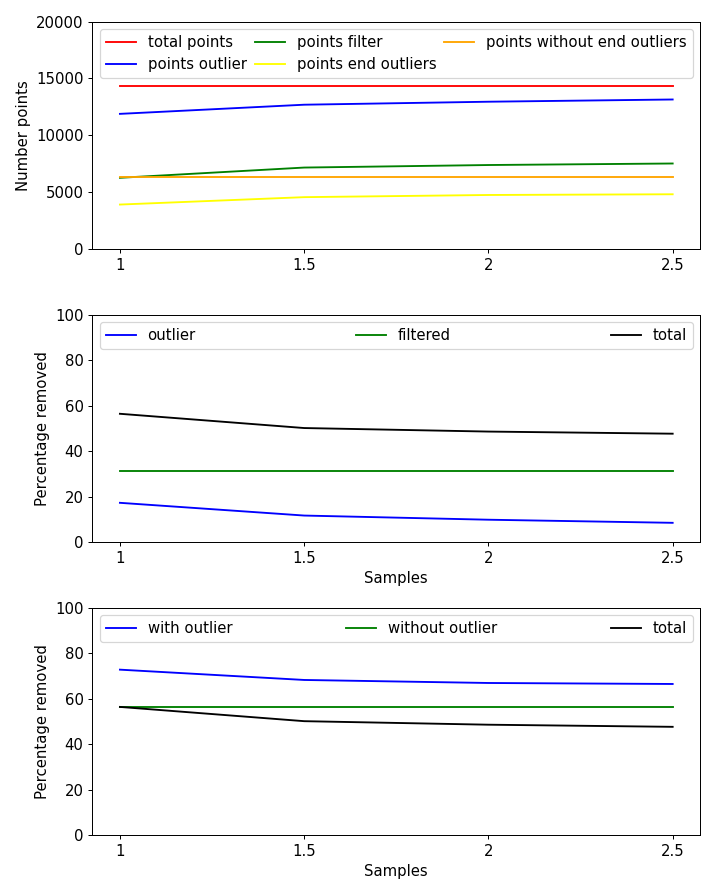

In [34]:
%matplotlib notebook
fig = plt.figure(figsize =(8,10))
ax = fig.add_subplot(311)
arr = ["1","1.5","2","2.5"]
#arr = ["0.5","1","1.5","2"]
#arr = ["0.5","1","1.5","2"]
ax.plot(mean_points_input, color='r', label="total points")
ax.plot(mean_point_out_outlier, color='b', label="points outlier")
ax.plot(mean_point_out_filter, color='g', label="points filter")
ax.plot(mean_points_out_outliers_end_with_outliers, color='yellow', label="points end outliers")
ax.plot(mean_points_out_outliers_end_without_outliers, color='orange', label="points without end outliers")
ax.set_ylabel("Number points")
#ax.set_ylim([0,200000])
ax.set_ylim([0,20000])
ax.legend(mode = "expand", ncol = 3)
plt.xticks([0, 1, 2, 3], arr)

ax2 = fig.add_subplot(312)
ax2.plot(percentage_out_outliers, color='b', label="outlier")
ax2.plot(percentage_out_filters, color='g', label="filtered")
ax2.plot(percentage_out_total, color='black', label="total")
ax2.legend(mode = "expand", ncol = 3)
ax2.set_ylim([0,100])
plt.xticks([0, 1, 2, 3], arr)
ax2.set_xlabel("Samples")
ax2.set_ylabel("Percentage removed")

ax3 = fig.add_subplot(313)
ax3.plot(percentage_out_outliers_with_outliers, color='b', label="with outlier")
ax3.plot(percentage_out_outliers_without_outliers, color='g', label="without outlier")
ax3.plot(percentage_out_total, color='black', label="total")
ax3.legend(mode = "expand", ncol = 3)
ax3.set_ylim([0,100])
plt.xticks([0, 1, 2, 3], arr)
ax3.set_xlabel("Samples")
ax3.set_ylabel("Percentage removed")

fig.tight_layout()
plt.show()
#fig.savefig("./figs/number_points_removed_distance-f-n-10-10-1.jpg")
#fig.savefig("./figs/number_points_removed_angle-f-10-n-n-1.jpg")
#fig.savefig("./figs/number_points_removed_time_split-f-2-1-1-n.jpg")